# Control analysis across the population 

In [31]:
# Load the tfa model 
from pytfa.io.json import load_json_model
model_file = 'reduced_model_ETC_core_20240710-100629_continuous.json'
tmodel = load_json_model(model_file)
#sol = tmodel.optimize()

2024-08-06 14:41:37,408 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [32]:
# Ploting tool 
import matplotlib.pyplot as plt
# Set arial 16 as the default font
plt.rcParams.update({'font.size': 16 , 'font.family': 'Arial'})  

In [33]:
# Reload and prepare the model
from skimpy.io.yaml import load_yaml_model
from skimpy.utils.tabdict import TabDict

kmodel = load_yaml_model(model_file.replace("_continuous.json", "_kinetic_curated.yml"))

# We calculate control coeffcients with respect
#  to enzyme activity and boundary concentrations
parameter_list = TabDict([(k, p.symbol) for k, p in kmodel.parameters.items() if p.name.startswith('vmax_forward')])
boundary_parameters = TabDict([(c.reactant.name, c.reactant.symbol) for c in kmodel.boundary_conditions.values()])
parameter_list.update(boundary_parameters)

# Compile the jacobian expressions
NCPU = 12
kmodel.prepare()
kmodel.compile_mca(ncpu=NCPU, parameter_list=parameter_list)

In [34]:
# Load TFA samples 
import pandas as pd
tfa_sample_file = 'reduced_model_ETC_core_20240710-100629_tfa_sampling.csv'
tfa_samples = pd.read_csv(tfa_sample_file)

In [35]:
# Load parameter samples 
from skimpy.core.parameters import load_parameter_population
parameter_population = load_parameter_population(tfa_sample_file.replace(".csv",'_pruned_parameters.hdf5'))

In [36]:
# Scaling parameters
CONCENTRATION_SCALING = 1e3 # 1 mol to 1 umol
TIME_SCALING = 1 # 1min
DENSITY = 1200 # g/L 
GDW_GWW_RATIO = 1.0 # Fluxes are in gWW

In [37]:
from skimpy.analysis.oracle.load_pytfa_solution import load_fluxes, load_concentrations,\
    load_equilibrium_constants
import numpy as np

flux_controll_coefficients = []
parameter_sample_ids = []

for k in parameter_population._index:

    parameter_values = parameter_population[k]

    i = int(k.split(',')[0]) 
    ref_solution = tfa_samples.loc[i]


    # Load fluxes and concentrations
    fluxes = load_fluxes(ref_solution, tmodel, kmodel,
                            density=DENSITY,
                            ratio_gdw_gww=GDW_GWW_RATIO,
                            concentration_scaling=CONCENTRATION_SCALING,
                            time_scaling=TIME_SCALING)
    
    concentrations = load_concentrations(ref_solution, tmodel, kmodel,
                                            concentration_scaling=CONCENTRATION_SCALING)
    
    this_fc = kmodel.flux_control_fun(fluxes,concentrations,[parameter_values, ])

    # Prune
    medium_control = this_fc.slice_by('sample', 0).loc[['L_LACt2r','GLCt1r', 'FATP1t', 'BHBt'],['lac_L_e', 'glc_D_e', 'hdca_e', 'bhb_e']]
    diag_is_positive = np.all(np.diag(medium_control.values) > 0)

    if diag_is_positive:
        flux_controll_coefficients.append(this_fc)
        parameter_sample_ids.append(k)


In [38]:
# Stack the results
from skimpy.utils.tensor import Tensor
import numpy as np
# Concat the data
data = np.concatenate([f._data for f in flux_controll_coefficients], axis=2)
# Conver to tensor 
indexes = flux_controll_coefficients[0].indexes['flux'], flux_controll_coefficients[0].indexes['parameter'], pd.Index(parameter_sample_ids, name='samples')
control_coefficients = Tensor(data, indexes )


In [39]:
from skimpy.utils.general import get_stoichiometry
S = get_stoichiometry(kmodel, kmodel.variables)

In [40]:
import seaborn as sns 
import matplotlib.pyplot as plt 

mean_flux_control = control_coefficients.quantile('samples', 0.5) #.mean('samples') #
mean_flux_control.columns = [i.replace("vmax_forward_", '') for i in mean_flux_control.columns ]

# Make FATP1t operated in reverse to uptake FA
rows = ['GLCt1r',  'L_LACt2r','FATP1t', 'BHBt','cyt_atp2adp']
# Parameters to exclude
excluded_parameters =  ['ATPS4mi', 'ATPtm','cyt_atp2adp' , 'na1_e','na1_c']
colums = [i for i in mean_flux_control.columns if i not in excluded_parameters]

mean_flux_control = mean_flux_control.loc[rows,colums]




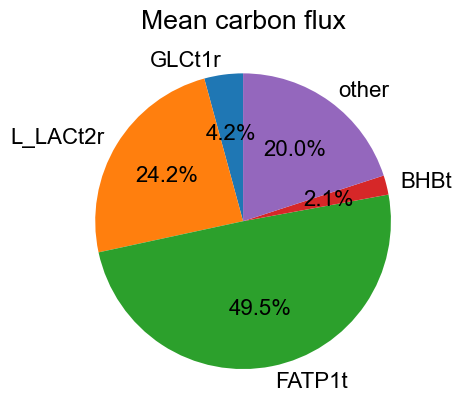

In [41]:
# Change font size to 16 
#plt.rcParams.update({'font.size': 16})

# Scale scale the uptake fluxes by the number of carbons
mean_fluxes = load_fluxes( tfa_samples.mean(), tmodel, kmodel,
                            density=DENSITY,
                            ratio_gdw_gww=GDW_GWW_RATIO,
                            concentration_scaling=1.,
                            time_scaling=TIME_SCALING)[rows].abs()

carbons = pd.Series({ 'GLCt1r': 6, 'L_LACt2r': 3, 'FATP1t': 16, 'BHBt': 4, 'cyt_atp2adp': 0})[rows]

mean_carbon_flux = mean_fluxes * carbons

# Add a column that accounts for 20% of the total flux and label it as 'other'
mean_carbon_flux['other'] = mean_carbon_flux.sum() * (1/0.80 - 1)

# Drop the cytosolic ATP/ADP exchange
mean_carbon_flux = mean_carbon_flux.drop('cyt_atp2adp', axis=0)

# A pie chart shoeing the distribution of the mean carbon flux:
fig, ax = plt.subplots()
mean_carbon_flux.plot.pie(ax=ax, subplots=True, figsize=(5,5), autopct='%1.1f%%', startangle=90)
plt.ylabel('')
ax.set_title('Mean carbon flux')

plt.show()

In [42]:
carbons = pd.Series({ 'GLCt1r': 6, 'L_LACt2r': 3, 'FATP1t': 16, 'BHBt': 4, 'cyt_atp2adp': 1})[rows]

mean_flux_control_corr = mean_flux_control#.multiply(mean_fluxes, axis=0).multiply(carbons, axis=0)
mean_flux_control_corr.head()

,ACACT1rm,ACONTm,ADK1,AKGDm,BDHm,BHBt,BHBtm,C160CPT1,C160CPT2,CO2t,...,r0205,r0509,r2435,bhb_e,co2_e,glc_D_e,h_e,hdca_e,lac_L_e,o2_e
flux,,,,,,,,,,,,,,,,,,,,,
GLCt1r,1.412418e-06,-3.761818e-05,-2.149066e-02,-0.003672,-2.711905e-04,-5.795548e-06,-7.770962e-06,0.007584,1.517802e-03,-9.514860e-05,...,-0.001188,4.617423e-05,6.513189e-05,-2.743191e-04,2.071428e-06,0.444108,-2.228229e-02,0.014751,-0.004545,-0.013407
L_LACt2r,-1.574712e-04,4.695546e-04,-2.613901e-02,0.041503,-8.907884e-02,-2.029269e-03,-2.726841e-03,-0.146353,-1.841313e-02,1.338819e-03,...,-0.002346,-5.787916e-04,-7.855422e-04,-9.117825e-02,-3.007581e-05,-0.089161,3.481504e-02,-0.918329,0.002714,-0.065213
FATP1t,1.313483e-05,-1.627763e-04,1.093881e-02,-0.014280,3.549912e-04,8.060331e-06,9.773470e-06,0.053803,6.566208e-03,-4.424298e-04,...,0.001130,2.189327e-04,2.835233e-04,3.612856e-04,9.947997e-06,0.004008,-2.235712e-02,0.339152,0.000374,0.019610
BHBt,4.817525e-04,-2.664804e-04,-9.466473e-03,-0.026176,9.375081e-01,2.152518e-02,2.812184e-02,0.015241,1.906497e-03,-9.278733e-04,...,-0.009821,-3.806518e-04,9.300002e-05,9.525699e-01,2.002340e-05,-0.031026,1.929389e-01,-0.073018,-0.055014,0.158340
cyt_atp2adp,2.139422e-09,-1.644567e-08,-3.931990e-07,-0.000002,2.972834e-07,6.784226e-09,9.179049e-09,0.000008,8.738461e-07,-3.300827e-08,...,-0.000002,4.728915e-08,4.423397e-08,3.006946e-07,7.370460e-10,-0.000007,-2.558823e-08,-0.000009,-0.000001,0.000003


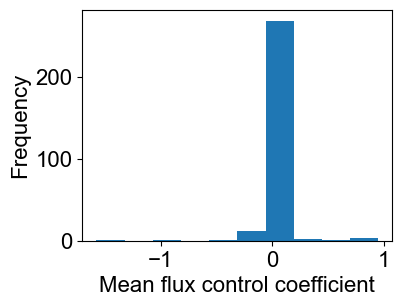

In [43]:
f, ax = plt.subplots(figsize=(4, 3))
plt.hist(mean_flux_control_corr.values.flatten(), bins=10)
plt.xlabel('Mean flux control coefficient')
plt.ylabel('Frequency')
plt.show()



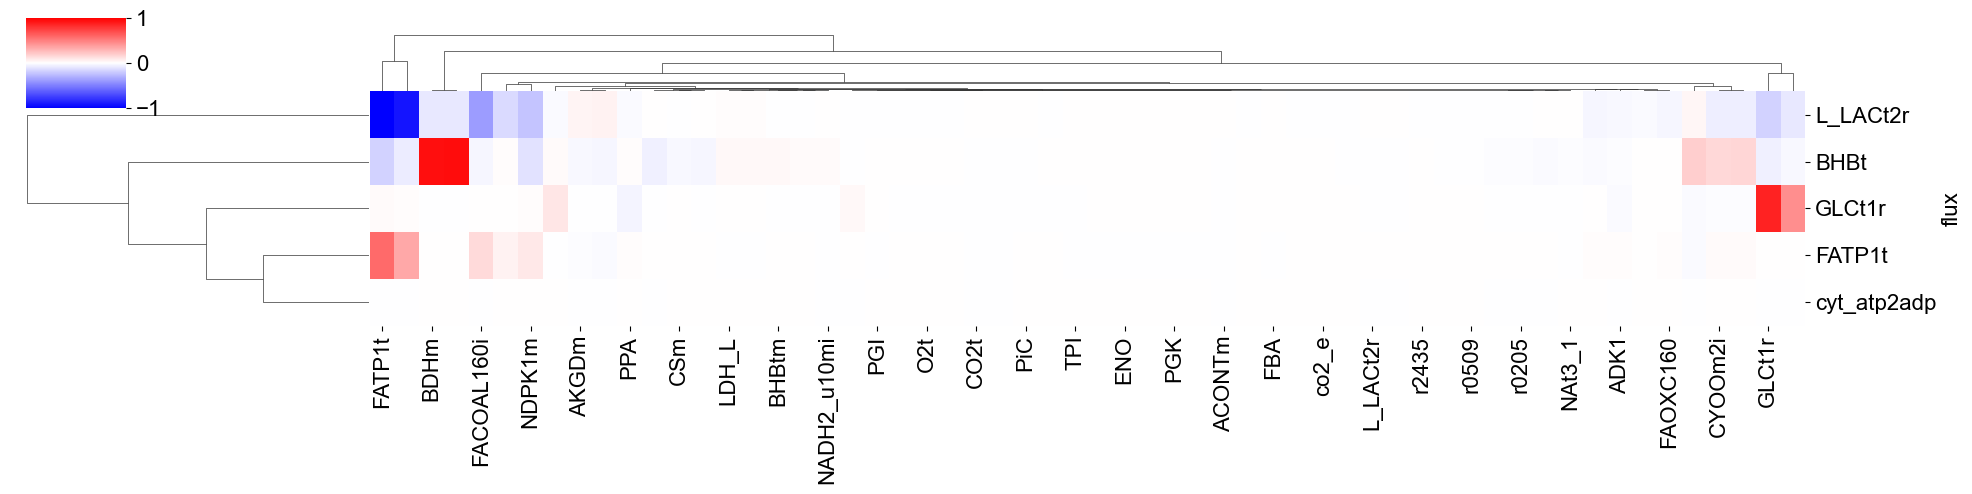

In [44]:

# Plot a cluster map of the flux control coefficients
sns.clustermap(mean_flux_control_corr,row_cluster=True,col_cluster=True, cmap='bwr', center=0, figsize=(20,5), vmin=-1, vmax=1) 
# Change the xtick to have all colm

plt.show()

In [45]:
# Get the parameter set that is closeset to the median flux control coefficients
median_control_coeffcienets = control_coefficients.quantile('samples', 0.5) 

distance_to_median = [((control_coefficients.slice_by('samples', i).loc[rows] - median_control_coeffcienets.loc[rows])**2).values.sum() for i in control_coefficients.indexes['samples']]

closest_to_median = control_coefficients.indexes['samples'][np.argmin(distance_to_median)]

print(f'Closest to median:{closest_to_median} with distance {np.min(distance_to_median)} (mean distance {np.mean(distance_to_median)})')


Closest to median:71,24 with distance 0.5856132374378138 (mean distance 6.975641254616242)


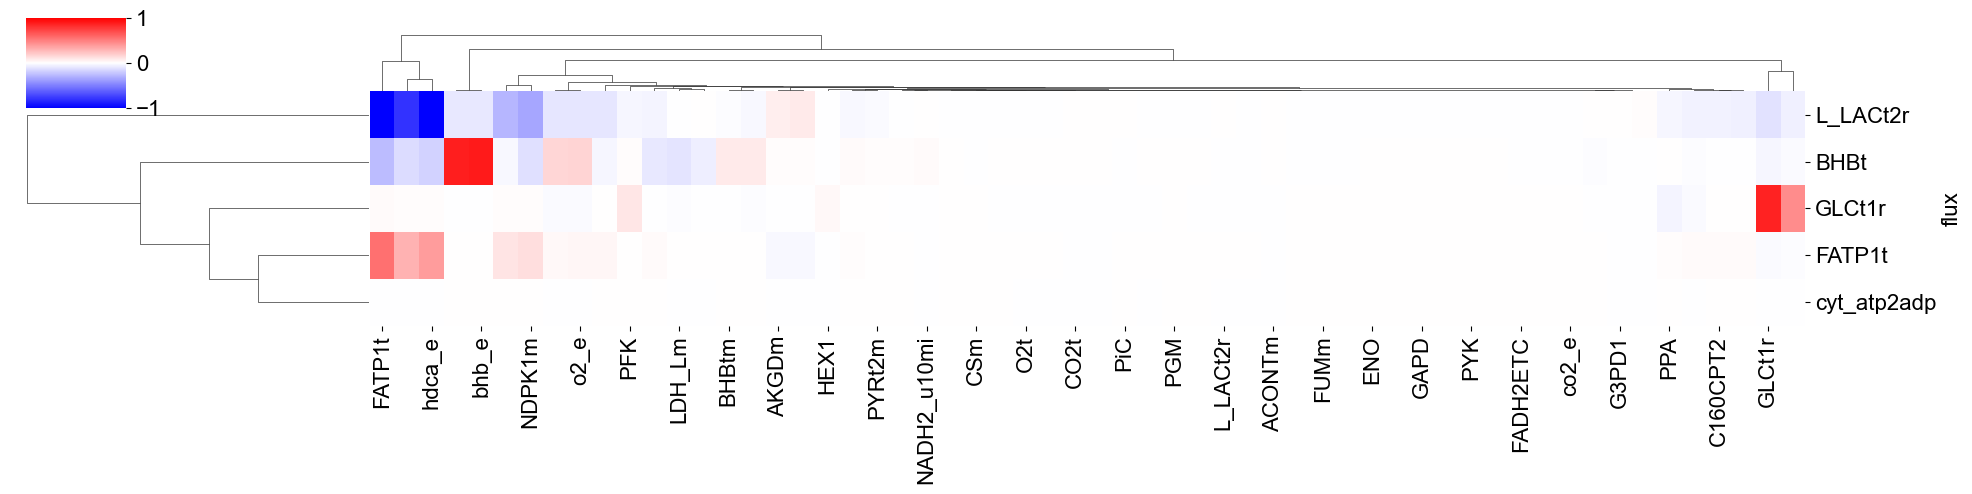

In [46]:
CC = control_coefficients.slice_by('samples',closest_to_median)
CC.columns = [i.replace("vmax_forward_", '') for i in CC.columns ]
# Plot a cluster map of the flux control coefficients
sns.clustermap(CC.loc[rows,colums],row_cluster=True,col_cluster=True, cmap='bwr', center=0, figsize=(20,5), vmin=-1.0, vmax=1.0)    
# Change the xtick to have all colm
plt.show()

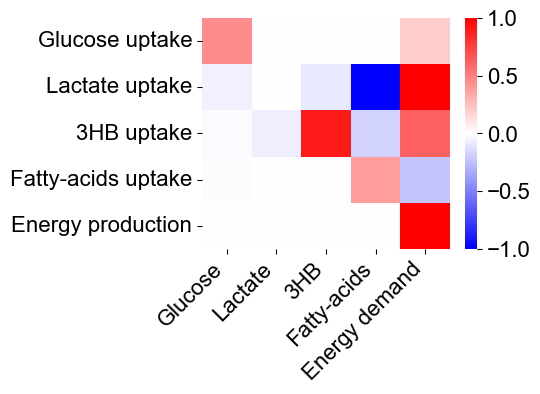

In [47]:
# Make a heat map only for concentration of the carbon sources 
colums = [ 'glc_D_e', 'lac_L_e','bhb_e','hdca_e', 'cyt_atp2adp']
rows = ['GLCt1r',  'L_LACt2r', 'BHBt', 'FATP1t','cyt_atp2adp']

f, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(CC.loc[rows,colums] , cmap='bwr', center=0, vmin=-1, vmax=1, )    

# Rename yticks and columns
ax.set_yticklabels(['Glucose uptake', 'Lactate uptake', '3HB uptake', 'Fatty-acids uptake', 'Energy production'])
ax.set_xticklabels(['Glucose', 'Lactate', '3HB', 'Fatty-acids', 'Energy demand'], rotation=45, ha='right')

plt.ylabel('')
plt.xlabel('')
plt.show()


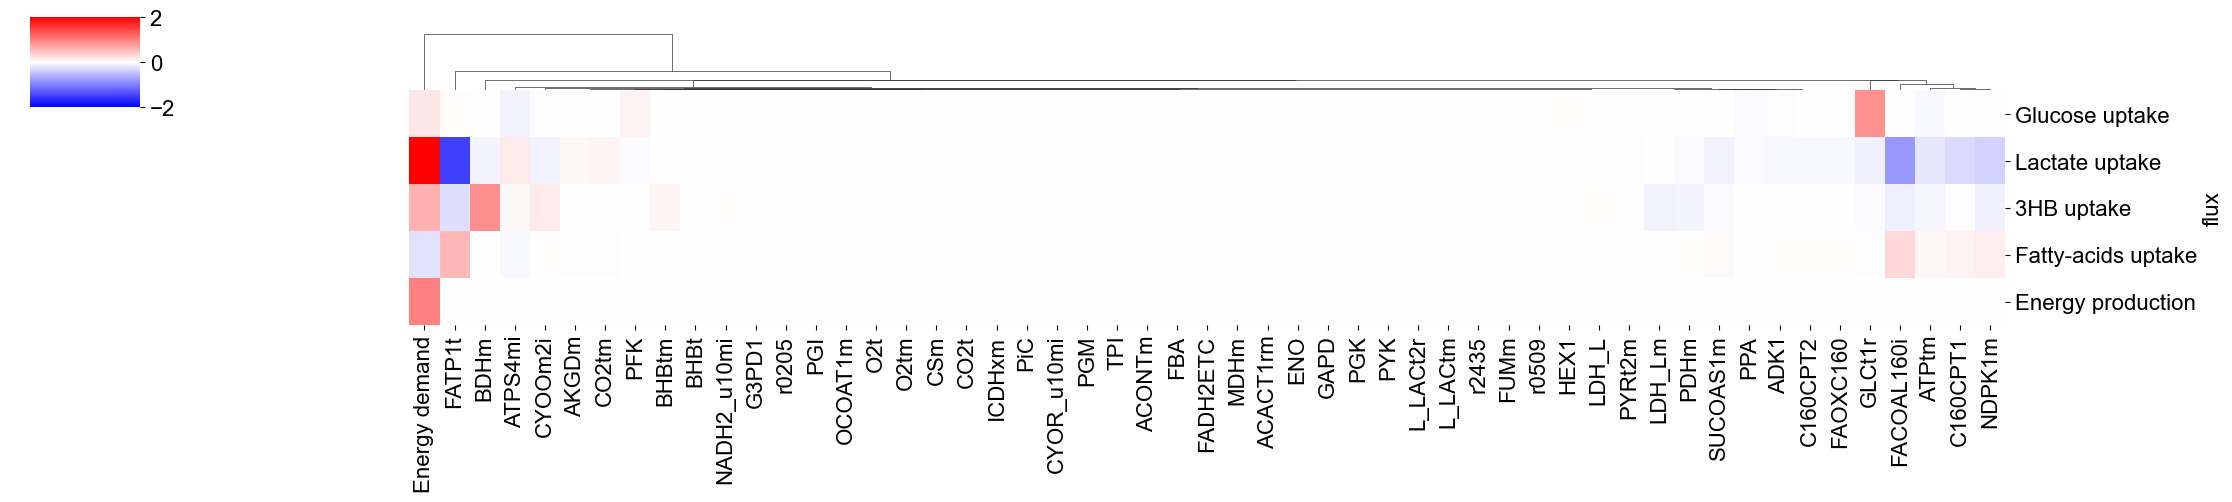

In [48]:
# Cluster enzyme activity control coefficients

CC = control_coefficients.slice_by('samples',closest_to_median)
CC.columns = [i.replace("vmax_forward_", '') for i in CC.columns ]

excluded_parameters = ['NAt3_1','na1_e','na1_c', 'h_e','co2_e','o2_e'] + [ 'glc_D_e', 'lac_L_e','bhb_e','hdca_e', ]
colums = [i for i in CC.columns if i not in excluded_parameters]

# Color by subsystem 
subsystems_dict = {r.id:r.subsystem for r in tmodel.reactions }
subsystems = pd.Series([subsystems_dict[c] for c in colums ])
#lut = dict(zip(subsystems.unique(),  ))
#col_colors = subsystems.map(lut)


# Plot a cluster map of the flux control coefficients
ax =sns.clustermap(CC.loc[rows,colums],row_cluster=False,col_cluster=True, cmap='bwr', center=0, metric='euclidean',method='ward',
                   figsize=(22,5) , vmin=-2.0, vmax=2.0, )# col_colors=col_colors)    


# Change y ticks to have the correct names
ax.ax_heatmap.set_yticklabels(['Glucose uptake', 'Lactate uptake', '3HB uptake', 'Fatty-acids uptake', 'Energy production'])
# Change cyt_atp2adp to 'Energy production' in the xticks leave the rest
xticks = ax.ax_heatmap.get_xticklabels()
xticks = [i.get_text() if i.get_text() != 'cyt_atp2adp' else 'Energy demand' for i in xticks]
ax.ax_heatmap.set_xticklabels(xticks, rotation=90, ha='center')

plt.savefig('./output/rep_flux_control_coefficients.pdf')
plt.show()


In [49]:
# Compile ODEs 
kmodel.compile_ode(ncpu=NCPU)

In [50]:
thermo_index = int(closest_to_median.split(',')[0])
thermo_sample = tfa_samples.loc[thermo_index]

concentrations = load_concentrations(thermo_sample, tmodel, kmodel, 
                                     concentration_scaling=CONCENTRATION_SCALING)

for k in kmodel.initial_conditions:
        kmodel.initial_conditions[k] = concentrations[k]


In [51]:
# # Test steady state
# sol = kmodel.solve_ode(np.linspace(0, 10, 1000), solver_type='cvode')
# #sol.concentrations.plot()


In [52]:
# Compute fluxes as a function of time 
from skimpy.analysis.ode.utils import make_flux_fun
from skimpy.utils.namespace import QSSA

flux_fun = make_flux_fun(kmodel, QSSA)

In [53]:
# Init pretty plotting stuff

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 5, 'capthick': 2, 'elinewidth': 2, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

# Color palate with basal, default, and perturbation colors
colors_basal = ['whitesmoke','lightsteelblue', 'steelblue']

# Color palate default, perturbation
colors_default = ['lightsteelblue', 'steelblue']

# Colors to highlight metabolites
# Glucose, lactate, 3HB, Fatty acids
colors_met = ['firebrick', 'lightcoral', 'wheat', 'gold']

# Greys 
colors_grey = ['lightgrey', 'darkgrey', 'dimgrey']

In [54]:
from skimpy.core.parameters import ParameterValues

UPTAKES_IN_CARBON = pd.Series({'GLCt1r':6, 'L_LACt2r':3,  'BHBt':4  ,'FATP1t':-16,}, dtype=float)

# units -> nmoles/min/gDW
# Scale to umol/min using a 25g Std mouse 
SCALE = 25/1000

# Compute the fluxes for a perturbation in the uptake of a carbon source
def compute_uptake_perturbation(variable, fold, kmodel=kmodel, parmeters=parameter_population[closest_to_median],
                                time = np.linspace(0, 10, 1000), solver_type='cvode',
                                parameter_perturbation=dict()):
    # kmodel -> is initiatlized and compiled above 
    # Get the initial value
    kmodel.parameters = parmeters

    p0 = kmodel.parameters[variable].value
    kmodel.parameters[variable].value = p0 * fold

    # Additional perturbations in fold changes
    for k, v in parameter_perturbation.items():
        p0 = kmodel.parameters[k].value
        kmodel.parameters[k].value = p0 * v

    # Solve the ODEs
    sol = kmodel.solve_ode(time, solver_type='cvode' ,  max_steps=1e9,)

    # Get parameters value set 
    parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
    parameter_values = ParameterValues(parameter_values, kmodel)

    steady_state_fluxes = pd.Series(flux_fun(sol.concentrations.iloc[-1], parameters=parameter_values), 
                                    index=kmodel.reactions.keys())

    result = steady_state_fluxes.loc[UPTAKES_IN_CARBON.keys()].multiply(UPTAKES_IN_CARBON, axis=0) * SCALE
    return result

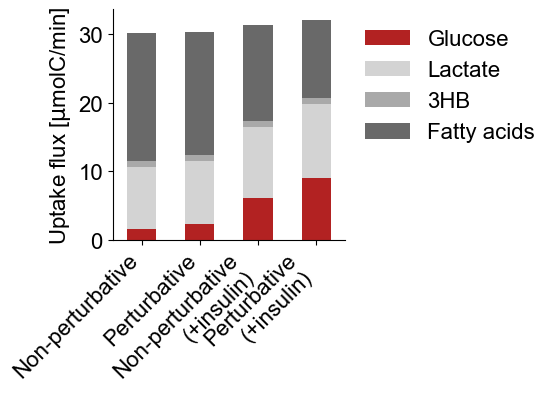

In [68]:
# Glucose infusion +/- inuslin effect 
non_pertubative = compute_uptake_perturbation('glc_D_e', 1)
pertubative = compute_uptake_perturbation('glc_D_e', 3)


insulin_effect = {'vmax_forward_GLCt1r': 5.0, 'vmax_forward_PFK': 2.0, 
                  'vmax_forward_C160CPT1': 1.0,}

non_pertubative_ins = compute_uptake_perturbation('glc_D_e', 1, parameter_perturbation=insulin_effect)
pertubative_ins = compute_uptake_perturbation('glc_D_e', 3, parameter_perturbation=insulin_effect)


df = pd.DataFrame({'Non-perturbative':non_pertubative, 'Perturbative':pertubative, 
                   'Non-perturbative\n(+insulin)':non_pertubative_ins, 'Perturbative\n(+insulin)':pertubative_ins}).T

df.columns = ['Glucose', 'Lactate', '3HB', 'Fatty acids']
colors = [colors_met[0],] + colors_grey

f, ax = plt.subplots(figsize=(3,3)) 
df.plot(kind='bar', stacked=True, color=colors, ax=ax, )
plt.xticks(rotation=45, ha='right') 
plt.ylabel('Uptake flux [$\mathrm{\mu}$molC/min]')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
sns.despine()

plt.savefig('./output/glucose_perturbation.svg')
plt.show()

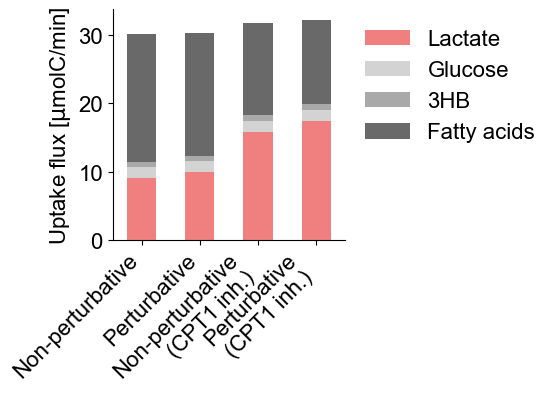

In [62]:
# Lactate infusion +/- PDH inhibition 
non_pertubative = compute_uptake_perturbation('lac_L_e', 1)
pertubative = compute_uptake_perturbation('lac_L_e', 4)

# Inhibition of CPT1 transport 
additional_effect = {'vmax_forward_C160CPT1': 0.3,}

non_pertubative_ins = compute_uptake_perturbation('lac_L_e', 1, parameter_perturbation=additional_effect)
pertubative_ins = compute_uptake_perturbation('lac_L_e', 4, parameter_perturbation=additional_effect)


df = pd.DataFrame({'Non-perturbative':non_pertubative, 'Perturbative':pertubative, 
                   'Non-perturbative\n(CPT1 inh.)':non_pertubative_ins, 'Perturbative\n(CPT1 inh.)':pertubative_ins}).T
# Sort index
df = df[['L_LACt2r',  'GLCt1r', 'BHBt', 'FATP1t']]
df.columns = ['Lactate', 'Glucose',  '3HB', 'Fatty acids']
colors = [colors_met[1],] + colors_grey

f, ax = plt.subplots(figsize=(3,3)) 
df.plot(kind='bar', stacked=True, color=colors, ax=ax, )
plt.xticks(rotation=45, ha='right') 
plt.ylabel('Uptake flux [$\mathrm{\mu}$molC/min]')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
sns.despine()

plt.savefig('./output/lactate_perturbation.svg')
plt.show()

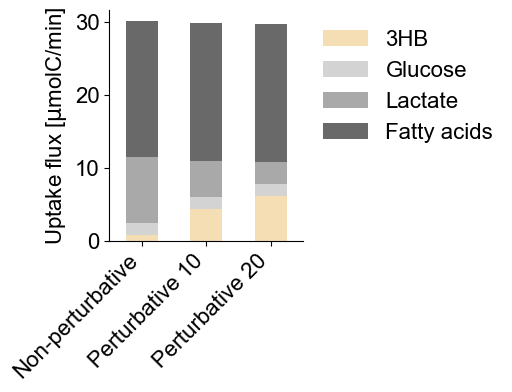

In [57]:
# 3HB infusion 
non_pertubative = compute_uptake_perturbation('bhb_e', 1)
pertubative_1 = compute_uptake_perturbation('bhb_e',10)
pertubative_2 = compute_uptake_perturbation('bhb_e',20)




df = pd.DataFrame({'Non-perturbative':non_pertubative, 'Perturbative 10':pertubative_1, 
                   'Perturbative 20':pertubative_2}).T
# Sort index
df = df[[  'BHBt','GLCt1r','L_LACt2r', 'FATP1t']]
df.columns = ['3HB', 'Glucose',  'Lactate', 'Fatty acids']
colors = [colors_met[2],] + colors_grey

f, ax = plt.subplots(figsize=(2.5,3)) 
df.plot(kind='bar', stacked=True, color=colors, ax=ax, )
plt.xticks(rotation=45, ha='right') 
plt.ylabel('Uptake flux [$\mathrm{\mu}$molC/min]')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
sns.despine()

plt.savefig('./output/3hb_perturbation.svg')
plt.show()


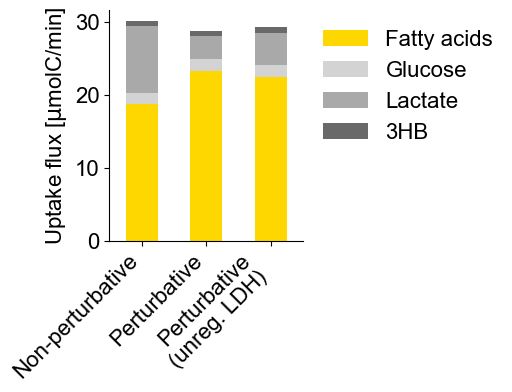

In [58]:
# FA infusion 
non_pertubative = compute_uptake_perturbation('hdca_e', 1)
pertubative = compute_uptake_perturbation('hdca_e', 2)

additional_effect = {#'k_inhibition_IM_accoa_m_PDHm': 1000 , 
                     #'k_activation_AM_nad_m_PDHm': 1000, 
                     'k_inhibition_IM_pmtcoa_c_LDH_L' : 10, 
                     }

#non_pertubative_pdh = compute_uptake_perturbation('hdca_e', 1, parameter_perturbation=additional_effect)
pertubative_pdh = compute_uptake_perturbation('hdca_e', 2, parameter_perturbation=additional_effect, time=np.linspace(0, 1.0, 1000))


df = pd.DataFrame({'Non-perturbative':non_pertubative, 'Perturbative':pertubative,'Perturbative\n(unreg. LDH)':pertubative_pdh,}).T

# Sort index
df = df[[  'FATP1t', 'GLCt1r','L_LACt2r','BHBt', ]]
df.columns = ['Fatty acids', 'Glucose',  'Lactate', '3HB', ]
colors = [colors_met[3],] + colors_grey

f, ax = plt.subplots(figsize=(2.5,3)) 
df.plot(kind='bar', stacked=True, color=colors, ax=ax, )
plt.xticks(rotation=45, ha='right') 
plt.ylabel('Uptake flux [$\mathrm{\mu}$molC/min]')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
sns.despine()

plt.savefig('./output/fatty_acid_perturbation.svg')
plt.show()

In [59]:
# TODO CLean up this coe below 

In [60]:
1/0

ZeroDivisionError: division by zero

In [ ]:
from skimpy.core.parameters import ParameterValues

# Compute a curve that captures the sensitivty of fasted fatty acids concentration to beta oxidation
ref_ffa = parameter_population[closest_to_median]['hdca_e']

ffa_conc = np.logspace(-1, 1, 100) * ref_ffa

uptakes = pd.Series({'GLCt1r':6, 'L_LACt2r':3, 'FATP1t':-16, 'BHBt':4 }, dtype=float)


kmodel.parameters = parameter_population[closest_to_median]

steady_state_fluxes_fasted = []

for ffa in ffa_conc:
    kmodel.parameters['hdca_e'].value = ffa
    sol = kmodel.solve_ode(np.linspace(0, 1, 100), solver_type='cvode' ,  max_steps=1e9,)
    # save the uptake fluxes
    parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
    parameter_values = ParameterValues(parameter_values, kmodel)
    this_fluxes = pd.Series(flux_fun(sol.concentrations.iloc[-1], parameters=parameter_values), index=kmodel.reactions.keys())
    this_fluxes = this_fluxes.loc[uptakes.keys()]

    steady_state_fluxes_fasted.append(this_fluxes)

steady_state_fluxes_fasted = pd.concat(steady_state_fluxes_fasted, axis=1).T
steady_state_fluxes_fasted[uptakes.keys()] = steady_state_fluxes_fasted[uptakes.keys()].multiply(uptakes, axis=1)




[CVODE ERROR]  CVode
  At t = 4.66441, the right-hand side routine failed in an unrecoverable manner.



SystemError: <method-wrapper '__getattribute__' of EnumMeta object at 0x7fa5fe8d02c0> returned a result with an error set

In [ ]:
# Compute a fed state perturbation 
kmodel.parameters = parameter_population[closest_to_median]

# Concentrations 
#kmodel.parameters['glc_D_e'].value = 7.5    # concentration in mM
#kmodel.parameters['lac_L_e'].value = 0.75    # concentration in mM Guess
#kmodel.parameters['hdca_e'].value = 0.2  # concentration in mM
#kmodel.parameters['bhb_e'].value = 0.1    # concentration in mM

# Insulin effect on glucose transport
#kmodel.parameters['vmax_forward_GLCt1r'].value = parameter_population[closest_to_median]['vmax_forward_GLCt1r'] * 10.0
#kmodel.parameters['vmax_forward_PFK'].value = parameter_population[closest_to_median]['vmax_forward_PFK'] * 10.0

# This is hypothetical 
#kmodel.parameters['vmax_forward_C160CPT2'].value = parameter_population[closest_to_median]['vmax_forward_C160CPT2'] * 0.5

In [ ]:
# Solve the ODE system to find the new steady-state
time = np.linspace(0,0.5, 500)
sol_fed = kmodel.solve_ode(time,solver_type='cvode')

Text(0, 0.5, 'Flux (mmolC/L/h)')

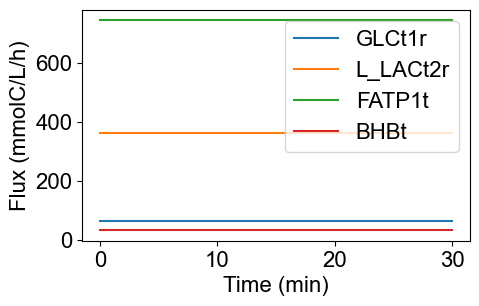

In [ ]:
from skimpy.core.parameters import ParameterValues
parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
parameter_values = ParameterValues(parameter_values, kmodel)

fluxes = pd.Series( flux_fun(concentrations=concentrations, parameters=parameter_population[closest_to_median]), index=kmodel.reactions.keys())

sol_fed_fluxes = pd.DataFrame( [ flux_fun(sol_fed.concentrations.loc[i], parameters=parameter_values) for i in  sol_fed.concentrations.index] , index=sol_fed.concentrations.index, columns=kmodel.reactions.keys())


time = sol_fed.time
sol_fed_fluxes_temp = sol_fed_fluxes.copy()
sol_fed_fluxes_temp['time'] = time  * 60
sol_fed_fluxes_temp[uptakes.keys()] = sol_fed_fluxes_temp[uptakes.keys()].multiply(uptakes, axis=1)
sol_fed_fluxes_temp.plot(x='time', y=uptakes.keys(), figsize=(5,3))

plt.xlabel('Time (min)')
plt.ylabel('Flux (mmolC/L/h)')

In [ ]:
# # # Explore regulation of what is likely to regulate energy demand by looking most sensitive metabolties to reduction of ATP demand
# kmodel.parameters = parameter_population[closest_to_median]

# # Change cyt_atp2adp incrase 2 fold  // this does not work
# kmodel.parameters['vmax_forward_cyt_atp2adp'].value = parameter_population[closest_to_median]['vmax_forward_cyt_atp2adp'] * 2.0
# #kmodel.parameters['vmax_forward_GLCt1r'].value = parameter_population[closest_to_median]['vmax_forward_GLCt1r'] * 10.0


In [ ]:
# Initial conditions
for k in kmodel.initial_conditions:
        kmodel.initial_conditions[k] = sol_fed.concentrations.iloc[-1][k]

In [ ]:
steady_state_fluxes_fed = []

for ffa in ffa_conc:
    kmodel.parameters['hdca_e'].value = ffa
    sol = kmodel.solve_ode(np.linspace(0, 10, 100), solver_type='cvode' ,  max_steps=1e9,)
    # save the uptake fluxes
    parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
    parameter_values = ParameterValues(parameter_values, kmodel)
    this_fluxes = pd.Series(flux_fun(sol.concentrations.iloc[-1], parameters=parameter_values), index=kmodel.reactions.keys())
    this_fluxes = this_fluxes.loc[uptakes.keys()]

    steady_state_fluxes_fed.append(this_fluxes)

steady_state_fluxes_fed = pd.concat(steady_state_fluxes_fed, axis=1).T
steady_state_fluxes_fed[uptakes.keys()] = steady_state_fluxes_fed[uptakes.keys()].multiply(uptakes, axis=1)

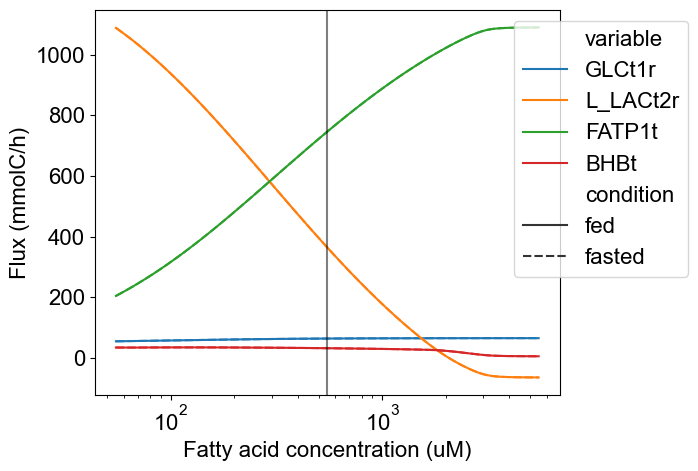

In [ ]:
steady_state_fluxes_fed['condition'] = 'fed'
steady_state_fluxes_fed['ffa'] = ffa_conc * 1e3 # Concentration in uM
steady_state_fluxes_fasted['condition'] = 'fasted'
steady_state_fluxes_fasted['ffa'] = ffa_conc * 1e3 # Concentration in uM

steady_state_fluxes = pd.concat([steady_state_fluxes_fed, steady_state_fluxes_fasted])

import seaborn as sns

steady_state_fluxes_db = steady_state_fluxes.melt(id_vars=['condition', 'ffa'], value_vars=['GLCt1r', 'L_LACt2r', 'FATP1t', 'BHBt'])
# Plot the uptake fluxes as a function of the fatty acid concentration
f, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(data=steady_state_fluxes_db, x='ffa', y='value', hue='variable', style='condition', ax =ax)
plt.xscale('log')
plt.xlabel('Fatty acid concentration (uM)')
plt.ylabel('Flux (mmolC/h)')

# Vertical line at ref_ffa
plt.axvline(ref_ffa * 1e3, color='k', linestyle='-', alpha =0.5)

# Legend outside the plot on the top right
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))


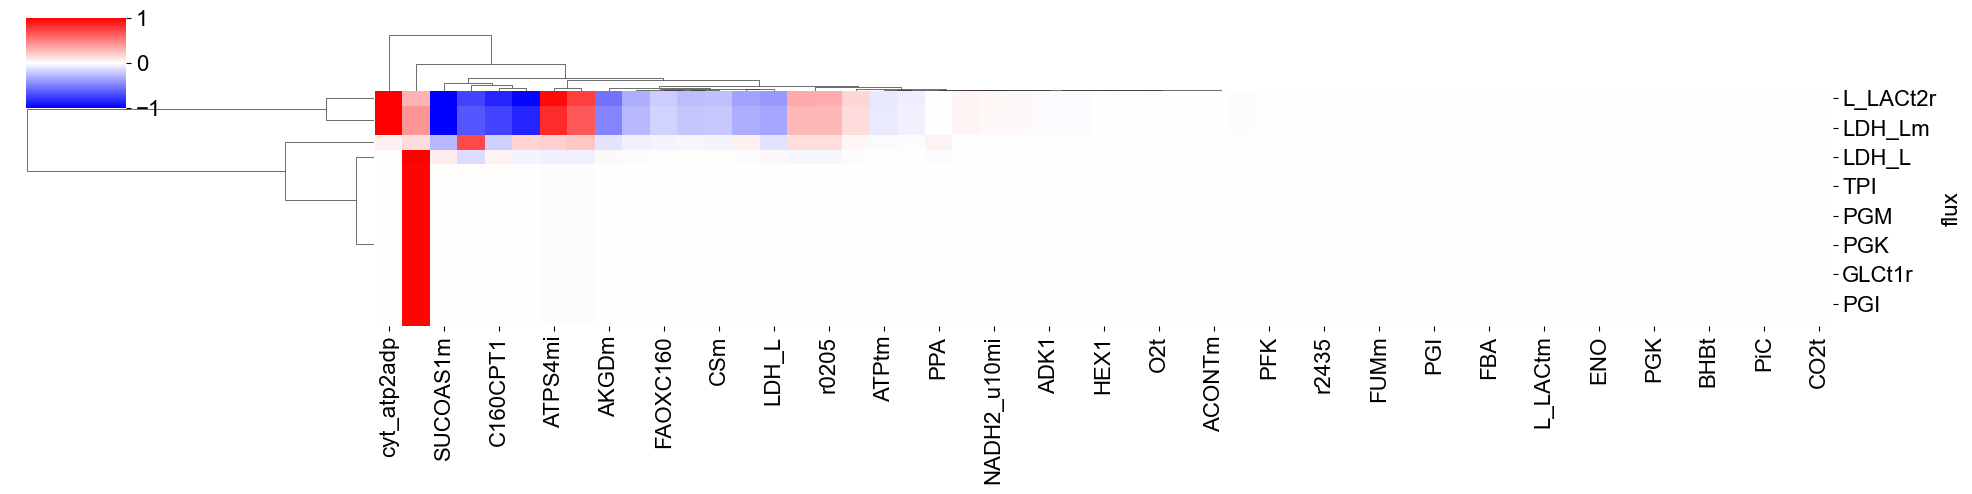

In [ ]:
glucose_resp = [ 'GLCt1r','HEX1', 'PGI', 'PFK', 'FBA', 'TPI', 'GAPD', 'PGK', 'PGM', 'ENO', 'PYK', 'PYRt2m', 'LDH_L',]
lactate_resp = [ 'L_LACt2r','L_LACtm', 'LDH_Lm', ]

lac_glu_rows = glucose_resp + lactate_resp
# Control coefficients in the new steady state
test_fc = kmodel.flux_control_fun(sol_fed_fluxes.iloc[-1],sol.concentrations.iloc[-1],[parameter_values, ]).slice_by('sample', 0)
test_fc.columns = [i.replace("vmax_forward_", '') for i in test_fc.columns ]
sns.clustermap(test_fc.loc[lac_glu_rows,colums], row_cluster=True, col_cluster=True, cmap='bwr', center=0, figsize=(20,5) , vmin=-1, vmax=1)

In [ ]:
# # Control coefficients in the new steady state
# test_cc = kmodel.concentration_control_fun(sol_fluxes.iloc[-1],sol.concentrations.iloc[-1],[parameter_values, ]).slice_by('sample', 0)
# sns.clustermap(test_cc, row_cluster=True, col_cluster=True, cmap='bwr', center=0, figsize=(20,20), vmin=-1, vmax=1)    

/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


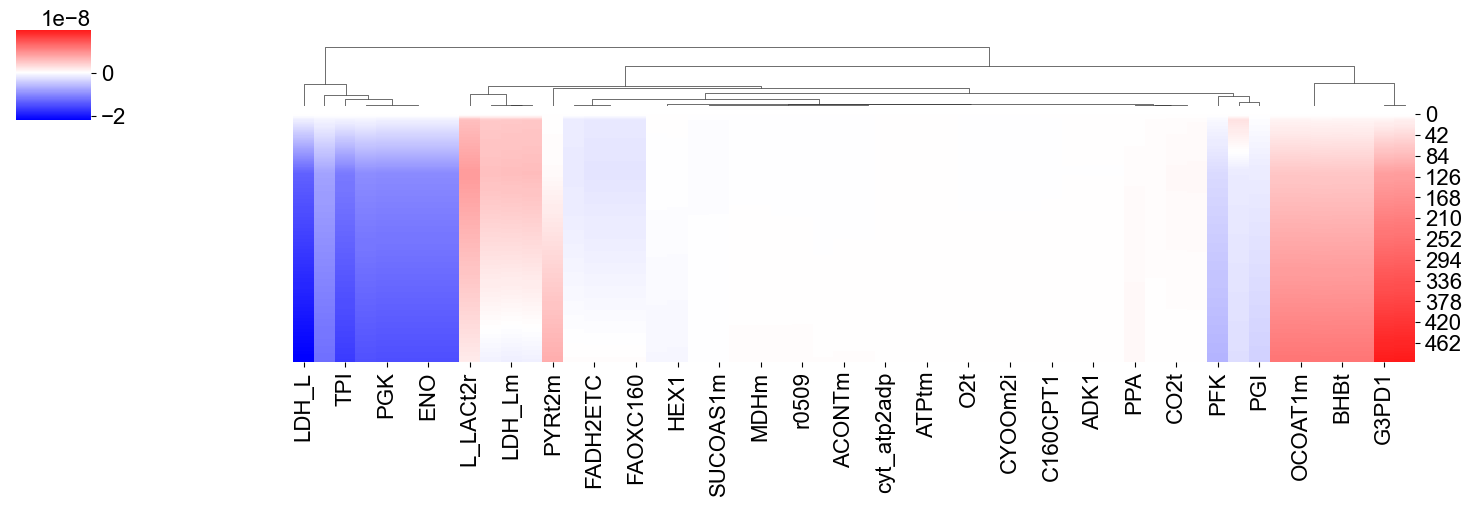

In [ ]:
# Convert the time series concentration in to a logic series of which elements start rising and which start falling in which order
fluxes_fold_change = np.log2(sol_fed_fluxes.div(fluxes, axis=1))
fluxes_fold_change = fluxes_fold_change.dropna(axis=1)

# Make a cluster map 
sns.clustermap(fluxes_fold_change, row_cluster=False, col_cluster=True, cmap='bwr', center=0, figsize=(15,5))
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


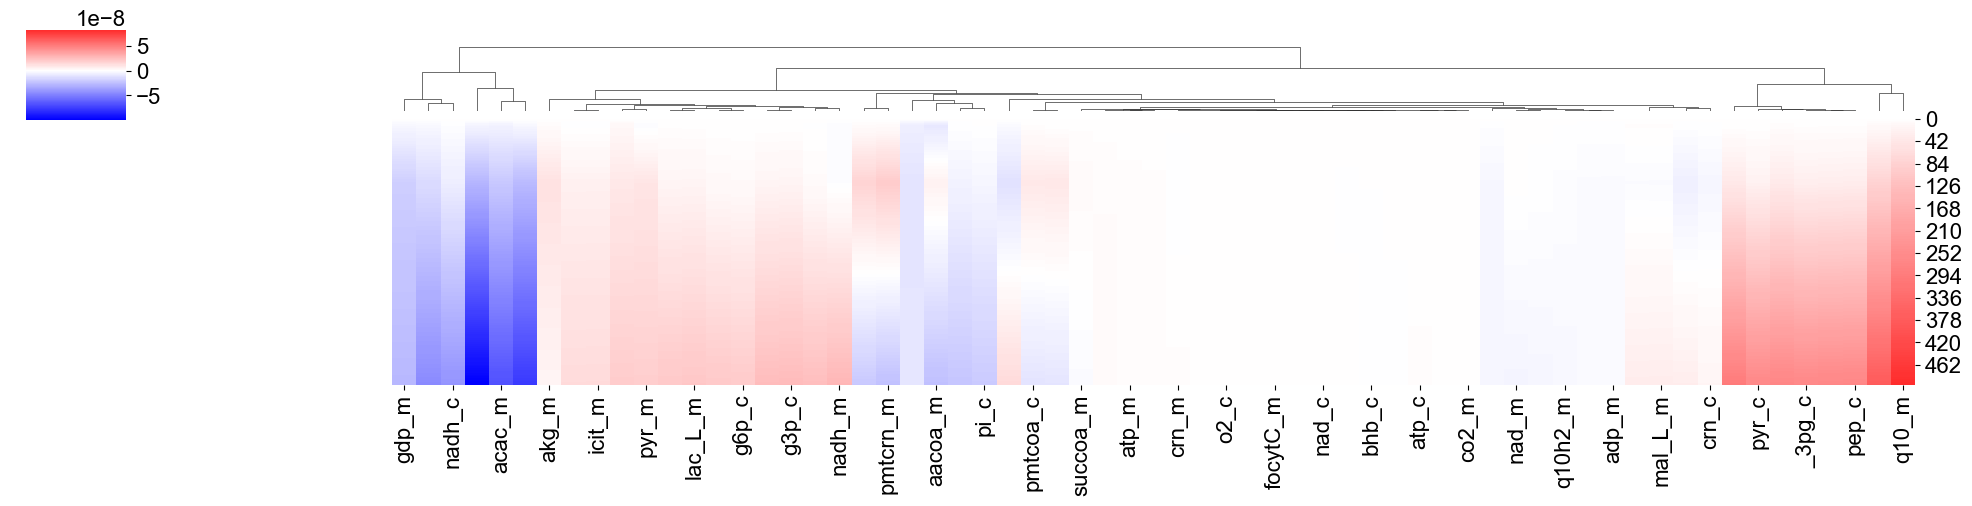

In [ ]:
# Convert the time series concen
concentrations_fold_change = np.log2(sol_fed.concentrations.div(concentrations, axis=1))
concentrations_fold_change = concentrations_fold_change.dropna(axis=1)

# Make a cluster map 
sns.clustermap(concentrations_fold_change, row_cluster=False, col_cluster=True, cmap='bwr', center=0, figsize=(20,5))
plt.show()

Text(0.5, 0, 'Time (min)')

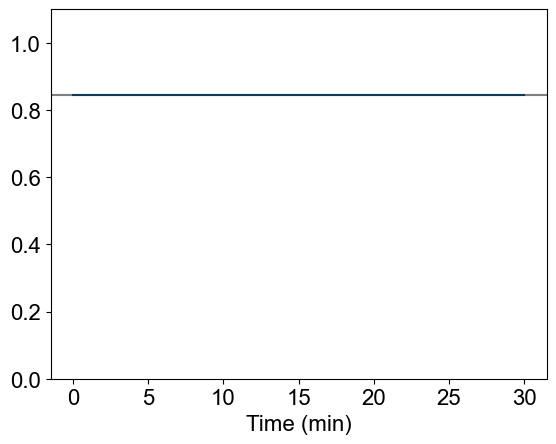

In [ ]:
# Compute complex I displacement (NADH2_u10mi)
k_eq = kmodel.reactions.NADH2_u10mi.parameters.k_equilibrium.value

gamma_complex_I = sol_fed.concentrations['q10h2_m'] * sol_fed.concentrations['nad_m'] * sol_fed.concentrations['h_c']**4 / ( sol_fed.concentrations['nadh_m'] * sol_fed.concentrations['q10_m'] * sol_fed.concentrations['h_m']**6) / k_eq 

gamma_complex_I_ref = concentrations['q10h2_m'] * concentrations['nad_m'] * concentrations['h_c']**4 / ( concentrations['nadh_m'] * concentrations['q10_m'] * concentrations['h_m']**6) / k_eq

plt.plot(sol_fed.time * 60, gamma_complex_I)

# Plot horizontal line at the reference value
plt.axhline(gamma_complex_I_ref, color='k', linestyle='-', alpha =0.5)
plt.ylim(0,1.1)
plt.xlabel('Time (min)')

In [ ]:
def metabolite_balance(met_id, data, tmodel):
    met = tmodel.metabolites.get_by_id(met_id)
    reactions = met.reactions

    # Find reaction that change direction
    changing_reactions = []
    for r in reactions:
        fluxes = data.loc[:,r.id]
        if fluxes.min() * fluxes.max() < 0:
            changing_reactions.append(r.id)
    
    ref_fluxes = data.loc[0,[r.id for r in reactions]]
    
    consumption =dict()
    production = dict()
    # Find reactions that are only producing or consuming the metabolite
    for r in reactions:
        stoich = r.metabolites[met]  
        if ref_fluxes[r.id] * stoich < 0 and not r.id in changing_reactions:
            consumption[r.id] = -stoich
        elif ref_fluxes[r.id] * stoich > 0 and not r.id in changing_reactions:
            production[r.id] = stoich
    
    production = pd.Series(production, dtype=float)
    consumption = pd.Series(consumption, dtype=float)
    
    # Build da results table
    production_fluxes = data.loc[:,production.keys()].multiply(production,axis=1).sum(axis=1)
    consumption_fluxes = data.loc[:,consumption.keys()].multiply(consumption,axis=1).sum(axis=1)

    fluxes = data.loc[:,changing_reactions]
    fluxes[f'{met_id} production'] = production_fluxes
    fluxes[f'{met_id} consumption'] = consumption_fluxes    

    return fluxes



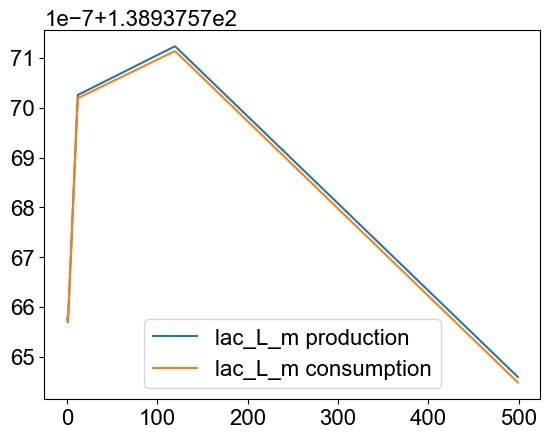

In [ ]:
balance = metabolite_balance('lac_L_m', sol_fed_fluxes, tmodel)
balance.plot()
plt.show()

Text(0, 0.5, '')

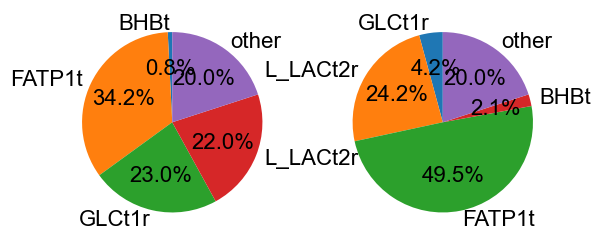

In [ ]:
# ANOTHER STORY

# To test how close to zero the dxdt is
flux_scaling_factor = 1e-3 / (GDW_GWW_RATIO / DENSITY) \
                        * CONCENTRATION_SCALING \
                        / TIME_SCALING

fluxes_profiles = pd.read_csv('reduced_model_ETC_core_20240710-100629_char_flux_profiles.csv', index_col=0)
# Convert from tfa to kintic flux spapce 
fluxes_profiles = fluxes_profiles * flux_scaling_factor

reaction_ix = list(kmodel.reactions.keys())


# Compute the mean carbon flux from fed fed state predition 
mean_carbon_flux_fed = fluxes_profiles.loc[:,'fed'].loc[rows].abs() * carbons

# Drop the cytosolic ATP/ADP exchange
mean_carbon_flux_fed = mean_carbon_flux_fed.drop('cyt_atp2adp', axis=0)

# Add a column that accounts for 25% of the total flux and label it as 'other'
mean_carbon_flux_fed['other'] = mean_carbon_flux_fed.sum() * (1/0.80 - 1)


# A pie chart shoeing the distribution of the mean carbon flux:
fig, ax = plt.subplots(1,2)
mean_carbon_flux_fed.plot.pie(ax=ax[0], subplots=True, figsize=(5,5), autopct='%1.1f%%', startangle=90)
mean_carbon_flux.plot.pie(ax=ax[1], subplots=True, figsize=(5,5), autopct='%1.1f%%', startangle=90)
plt.ylabel('')


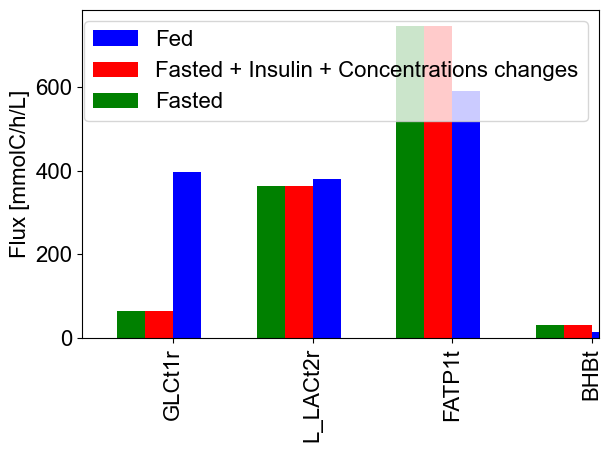

In [ ]:
# Compare uptake fluxes between simulated and inferred
uptakes = pd.Series({'GLCt1r':6, 'L_LACt2r':3, 'FATP1t':-16, 'BHBt':4 }, dtype=float)
# Plot target and predicted fluxes as stacked bars next to each other
fig, ax = plt.subplots(1,1)

target_fluxes = fluxes_profiles.loc[uptakes.keys(),'fed'].multiply(uptakes, axis=0)
predicted_fluxes = sol_fed_fluxes[uptakes.keys()].iloc[-1].multiply(uptakes, axis=0)
original_fluxes = fluxes_profiles.loc[uptakes.keys(),'fasted'].multiply(uptakes, axis=0)

target_fluxes.plot(kind='bar', ax=ax, color='b', position=0, width=0.2, label='Fed')
predicted_fluxes.plot(kind='bar', ax=ax, color='r', position=1, width=0.2, label='Fasted + Insulin + Concentrations changes')
original_fluxes.plot(kind='bar', ax=ax, color='g', position=2, width=0.2, label='Fasted')

plt.ylabel('Flux [mmolC/h/L]')
plt.legend()
plt.tight_layout()
plt.show()